In [3]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib 

# ARIMA Modeling
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# LSTM Modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

# Load Processed Data from Task 1
try:
    close_prices = pd.read_csv('../data/processed/close_prices.csv', index_col='Date', parse_dates=True)
    print("Processed data loaded successfully.")
except FileNotFoundError:
    print("Error: Processed data file not found. Please run the Task 1 notebook first.")
    # Exit or handle error appropriately
    exit()

# Isolate the target variable: TSLA closing price
tsla_data = close_prices['TSLA'].asfreq('B').fillna(method='ffill') # Ensure business day frequency and forward-fill any gaps

Processed data loaded successfully.


C:\Users\Yoga i7\AppData\Local\Temp\ipykernel_11732\4179369630.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tsla_data = close_prices['TSLA'].asfreq('B').fillna(method='ffill') # Ensure business day frequency and forward-fill any gaps


Training data length: 2219
Testing data length: 413


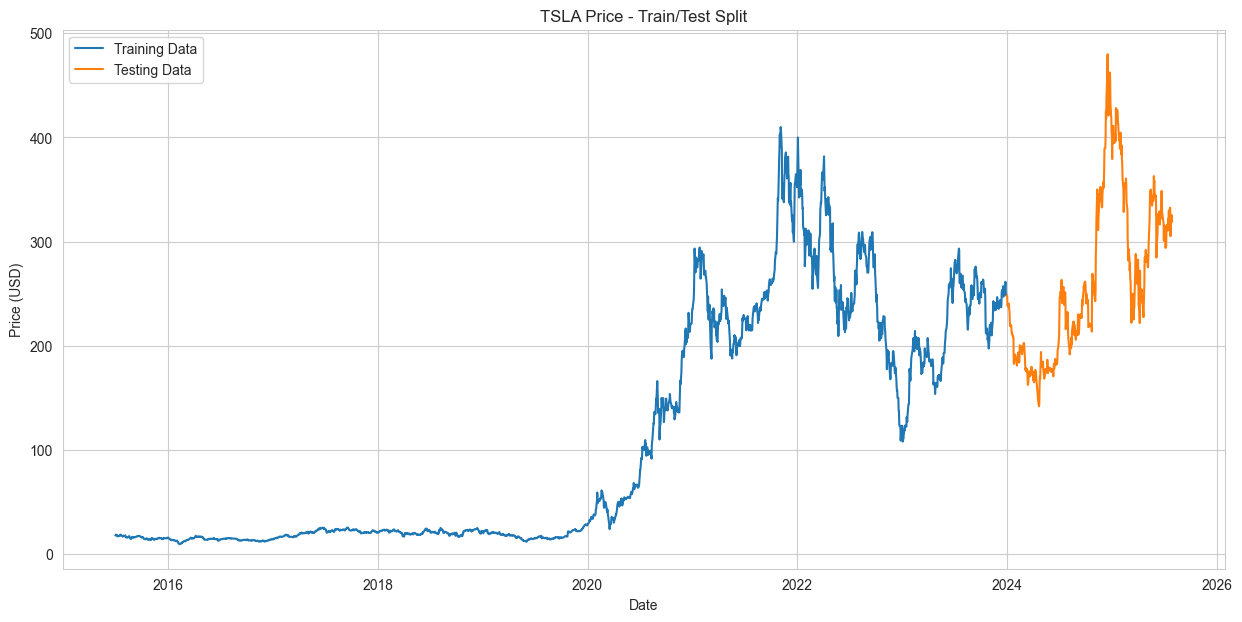

In [4]:
# Define the split point
split_date = '2024-01-01'

# Split the data
train_data = tsla_data[:split_date]
test_data = tsla_data[split_date:]

print(f"Training data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

# Visualize the split
plt.figure()
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data')
plt.title('TSLA Price - Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Finding the best ARIMA model using auto_arima...
Performing stepwise search to minimize aic


d:\Documents\Projects\10 Academy\Week-11\TimeSeries-Driven-Portfolio-Optimization\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Documents\Projects\10 Academy\Week-11\TimeSeries-Driven-Portfolio-Optimization\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Documents\Projects\10 Academy\Week-11\TimeSeries-Driven-Portfolio-Optimization\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Documents\Projects\10 Academy\Week-11\TimeSeries-Driven-Portfolio-Optimization\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14071.965, Time=1.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14071.244, Time=0.09 sec


d:\Documents\Projects\10 Academy\Week-11\TimeSeries-Driven-Portfolio-Optimization\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Documents\Projects\10 Academy\Week-11\TimeSeries-Driven-Portfolio-Optimization\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14071.100, Time=0.18 sec


d:\Documents\Projects\10 Academy\Week-11\TimeSeries-Driven-Portfolio-Optimization\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14071.106, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14069.964, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.588 seconds

--- auto_arima Summary ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2219
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7033.982
Date:                Tue, 12 Aug 2025   AIC                          14069.964
Time:                        13:29:39   BIC                          14075.669
Sample:                    07-01-2015   HQIC                         14072.048
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

d:\Documents\Projects\10 Academy\Week-11\TimeSeries-Driven-Portfolio-Optimization\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


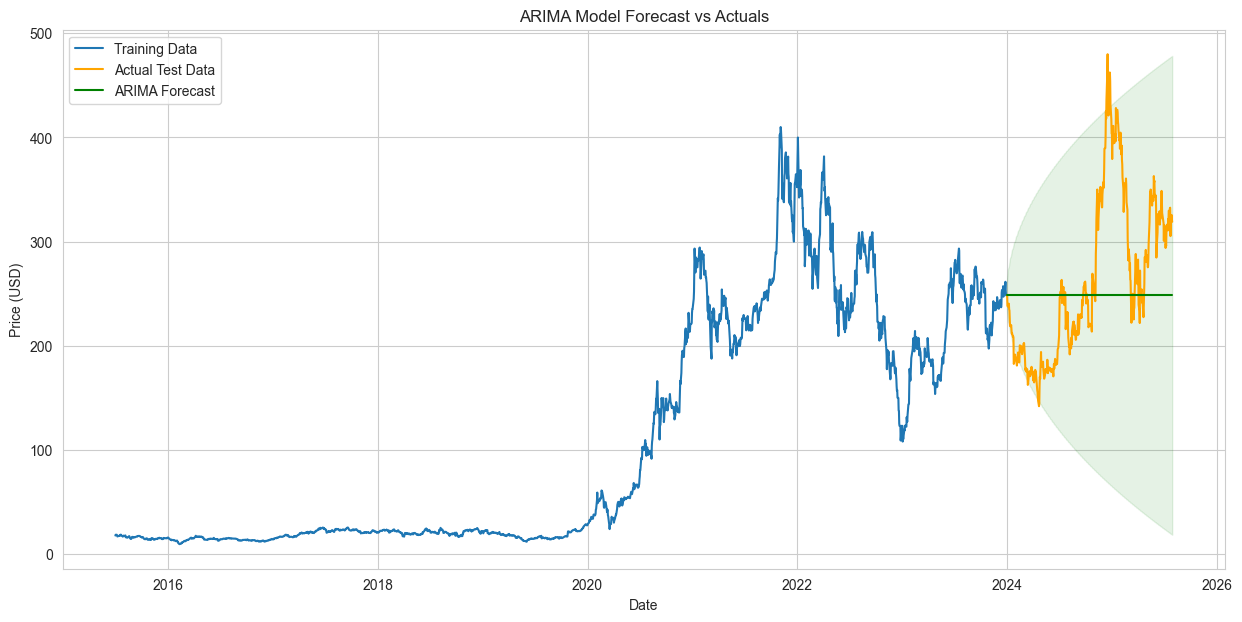

ARIMA model saved to ../models/arima_model.pkl


In [5]:
# --- Find Best ARIMA Parameters using auto_arima ---
# auto_arima will perform a search over different combinations of p,d,q
# and return the best model based on AIC (Akaike Information Criterion).
print("Finding the best ARIMA model using auto_arima...")
auto_arima_model = pm.auto_arima(
    train_data,
    start_p=1, start_q=1,
    test='adf',       # Use ADF test to find the best 'd'
    max_p=5, max_q=5, # Maximum p and q
    m=1,              # No seasonality
    d=None,           # Let the model determine 'd'
    seasonal=False,   # No seasonality
    start_P=0,
    D=0,
    trace=True,       # Print status updates
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True     # Use stepwise algorithm to speed up the search
)

print("\n--- auto_arima Summary ---")
print(auto_arima_model.summary())

# --- Train the final ARIMA model on the full training data ---
# The best parameters are extracted from the auto_arima result
p, d, q = auto_arima_model.order
final_arima_model = ARIMA(train_data, order=(p, d, q)).fit()

# --- Make Forecasts ---
n_periods = len(test_data)
arima_forecast = final_arima_model.get_forecast(steps=n_periods)
arima_forecast_mean = arima_forecast.predicted_mean
arima_confidence_intervals = arima_forecast.conf_int()

# --- Visualize the Forecast ---
plt.figure()
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data', color='orange')
plt.plot(test_data.index, arima_forecast_mean, label='ARIMA Forecast', color='green')
plt.fill_between(test_data.index,
                 arima_confidence_intervals.iloc[:, 0],
                 arima_confidence_intervals.iloc[:, 1], color='g', alpha=0.1)
plt.title('ARIMA Model Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# --- Save the ARIMA model ---
MODELS_PATH = '../models/'
os.makedirs(MODELS_PATH, exist_ok=True)
joblib.dump(final_arima_model, os.path.join(MODELS_PATH, 'arima_model.pkl'))
print(f"ARIMA model saved to {os.path.join(MODELS_PATH, 'arima_model.pkl')}")

In [6]:
# Scale the Data 
# LSTMs are sensitive to the scale of the input data. We'll use MinMaxScaler.
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler ONLY on the training data to avoid data leakage
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Transform the test data using the fitted scaler
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))

# --- Create Sequences ---
# We'll create a function to prepare the data in the format (samples, timesteps, features)
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Define the number of past days to use for prediction
time_step = 60 # Using 60 days of historical data

X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2158, 60, 1)
y_train shape: (2158,)
X_test shape: (352, 60, 1)
y_test shape: (352,)


In [7]:
# Build the LSTM Model 
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

# --- Define Callbacks ---
# EarlyStopping to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint to save the best model during training
LSTM_MODEL_PATH = os.path.join(MODELS_PATH, 'lstm_model.h5')
model_checkpoint = ModelCheckpoint(LSTM_MODEL_PATH, save_best_only=True, monitor='val_loss')

# --- Train the Model ---
print("\nTraining the LSTM model...")
history = lstm_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50, # A reasonable number of epochs
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model saved by ModelCheckpoint
lstm_model = load_model(LSTM_MODEL_PATH)
print(f"Best LSTM model loaded from {LSTM_MODEL_PATH}")

d:\Documents\Projects\10 Academy\Week-11\TimeSeries-Driven-Portfolio-Optimization\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)


Training the LSTM model...
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0500

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0493 - val_loss: 0.0075
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0044

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0027

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 5/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0021

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0020 - val_loss: 0.0060
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0022 - val_loss: 0.0058
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0019

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 11/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0017

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 12/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0015

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0014

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 16/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 17/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0016

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 18/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0013

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 19/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0016

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 20/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0012

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 21/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 22/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 23/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 24/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 25/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 26/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0012

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 27/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 28/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0011

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 29/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0011

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 30/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 31/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 32/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 33/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0010

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 34/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 35/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0010

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 36/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 9.9542e-04 - val_loss: 0.0025
Epoch 37/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 38/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 9.9428e-04 - val_loss: 0.0021
Epoch 39/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9.1227e-04

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 9.1626e-04 - val_loss: 0.0019
Epoch 40/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 41/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 42/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 43/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 44/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 9.9383e-04

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 9.8976e-04 - val_loss: 0.0017
Epoch 45/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.4838e-04

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 9.4971e-04 - val_loss: 0.0017
Epoch 46/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 9.4814e-04 - val_loss: 0.0018
Epoch 47/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 48/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 9.5198e-04

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 9.5483e-04 - val_loss: 0.0017
Epoch 49/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 50/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0010 - val_loss: 0.0021


Best LSTM model loaded from ../models/lstm_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


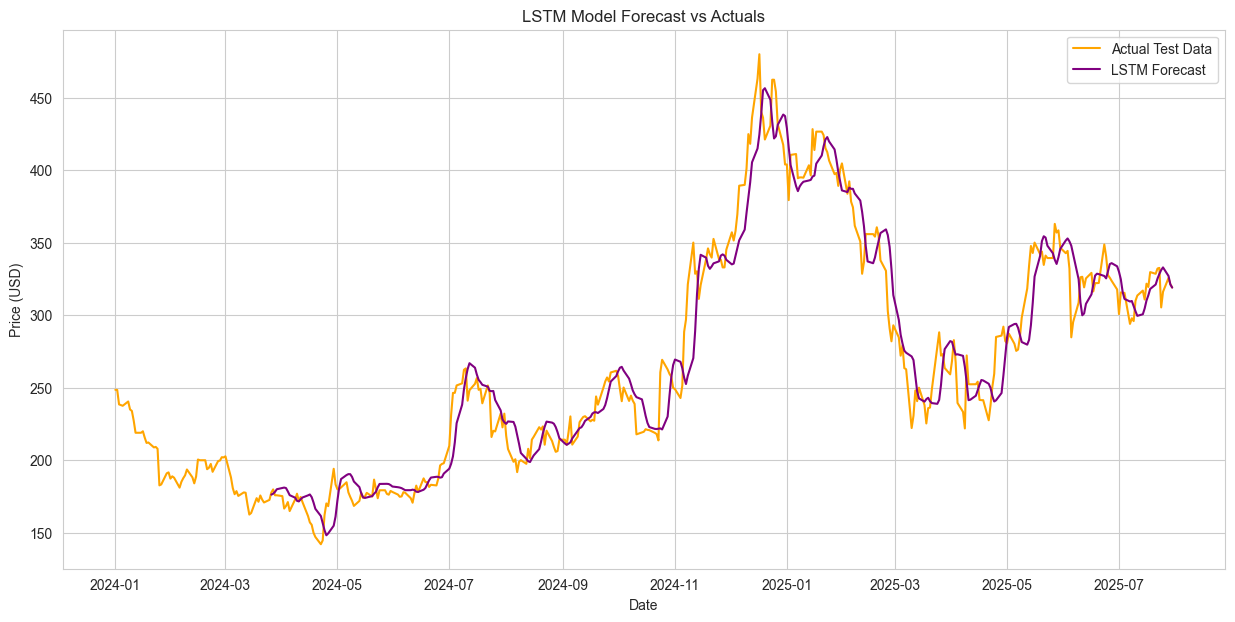

In [8]:
# Make Predictions on the Test Set 
# We predict on the X_test we created earlier
lstm_predictions_scaled = lstm_model.predict(X_test)

# Inverse transform the predictions to get the actual price values
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# --- Visualize the Forecast ---
# We need to align the predictions with the correct dates from the test set
# The predictions start 'time_step' days after the start of the test data
prediction_dates = test_data.index[time_step+1:]

plt.figure()
plt.plot(test_data.index, test_data.values, label='Actual Test Data', color='orange')
plt.plot(prediction_dates, lstm_predictions, label='LSTM Forecast', color='purple')
plt.title('LSTM Model Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [9]:
# Helper function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Evaluate ARIMA 
# Align the ARIMA forecast with the test data
arima_true_values = test_data.values
arima_pred_values = arima_forecast_mean.values
arima_metrics = calculate_metrics(arima_true_values, arima_pred_values)

# Evaluate LSTM
# Align the LSTM forecast with its corresponding true values
lstm_true_values = test_data.values[time_step+1:]
lstm_pred_values = lstm_predictions
lstm_metrics = calculate_metrics(lstm_true_values, lstm_pred_values)

# Create a Comparison Table
metrics_df = pd.DataFrame({
    'ARIMA': arima_metrics,
    'LSTM': lstm_metrics
})

print("\n Model Performance Comparison ")
print(metrics_df.round(4))


 Model Performance Comparison 
        ARIMA     LSTM
MAE   63.7214  14.8564
RMSE  79.0267  19.8381
MAPE   0.2416   0.0545
